In [455]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [456]:
train_data = pd.read_csv('D:/data/Alpha/train_dataset.csv')
test_data = pd.read_csv('D:/data/Alpha/test_dataset.csv')

In [457]:
train_data.head()


,用户编码,用户实名制是否通过核实,用户年龄,是否大学生客户,是否黑名单客户,是否4G不健康客户,用户网龄（月）,用户最近一次缴费距今时长（月）,缴费用户最近一次缴费金额（元）,用户近6个月平均消费值（元）,...,当月是否景点游览,当月是否体育场馆消费,当月网购类应用使用次数,当月物流快递类应用使用次数,当月金融理财类应用使用总次数,当月视频播放类应用使用次数,当月飞机类应用使用次数,当月火车类应用使用次数,当月旅游资讯类应用使用次数,信用分
0,a4651f98c82948b186bdcdc8108381b4,1,44,0,0,0,186,1,99.80,163.86,...,1,1,713,0,2740,7145,0,0,30,664
1,aeb10247db4e4d67b2550bbc42ff9827,1,18,0,0,1,5,1,29.94,153.28,...,0,0,414,0,2731,44862,0,0,0,530
2,5af23a1e0e77410abb25e9a7eee510aa,1,47,0,0,0,145,1,49.90,109.64,...,0,0,3391,0,0,4804,0,0,1,643
3,43c64379d3c24a15b8478851b22049e4,1,55,0,0,0,234,1,99.80,92.97,...,1,1,500,0,1931,3141,0,0,5,649
4,f1687f3b8a6f4910bd0b13eb634056e2,1,40,0,0,0,76,1,49.90,95.47,...,1,0,522,0,64,59,0,0,0,648


In [458]:
print(train_data.columns)

Index(['用户编码', '用户实名制是否通过核实', '用户年龄', '是否大学生客户', '是否黑名单客户', '是否4G不健康客户',
       '用户网龄（月）', '用户最近一次缴费距今时长（月）', '缴费用户最近一次缴费金额（元）', '用户近6个月平均消费值（元）',
       '用户账单当月总费用（元）', '用户当月账户余额（元）', '缴费用户当前是否欠费缴费', '用户话费敏感度', '当月通话交往圈人数',
       '是否经常逛商场的人', '近三个月月均商场出现次数', '当月是否逛过福州仓山万达', '当月是否到过福州山姆会员店', '当月是否看电影',
       '当月是否景点游览', '当月是否体育场馆消费', '当月网购类应用使用次数', '当月物流快递类应用使用次数',
       '当月金融理财类应用使用总次数', '当月视频播放类应用使用次数', '当月飞机类应用使用次数', '当月火车类应用使用次数',
       '当月旅游资讯类应用使用次数', '信用分'],
      dtype='object')


In [459]:
train_data.columns = ['uid','true_name_flag','age','uni_student_flag','blk_list_flag',\
                     '4g_unhealth_flag','net_age_till_now','top_up_month_diff','top_up_amount',\
                     'recent_6month_avg_use','total_account_fee','curr_month_balance',\
                     'curr_overdue_flag','cost_sensitivity','connect_num','freq_shopping_flag',\
                     'recent_3month_shopping_count','wanda_flag','sam_flag','movie_flag',\
                     'tour_flag','sport_flag','online_shopping_count','express_count',\
                     'finance_app_count','video_app_count','flight_count','train_count',\
                     'tour_app_count','score']
test_data.columns = train_data.columns[:-1]

In [460]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
uid                             50000 non-null object
true_name_flag                  50000 non-null int64
age                             50000 non-null int64
uni_student_flag                50000 non-null int64
blk_list_flag                   50000 non-null int64
4g_unhealth_flag                50000 non-null int64
net_age_till_now                50000 non-null int64
top_up_month_diff               50000 non-null int64
top_up_amount                   50000 non-null float64
recent_6month_avg_use           50000 non-null float64
total_account_fee               50000 non-null float64
curr_month_balance              50000 non-null int64
curr_overdue_flag               50000 non-null int64
cost_sensitivity                50000 non-null int64
connect_num                     50000 non-null int64
freq_shopping_flag              50000 non-null int64
recent_3month_shopping_count    5000

In [461]:



train_data.describe()

,true_name_flag,age,uni_student_flag,blk_list_flag,4g_unhealth_flag,net_age_till_now,top_up_month_diff,top_up_amount,recent_6month_avg_use,total_account_fee,...,tour_flag,sport_flag,online_shopping_count,express_count,finance_app_count,video_app_count,flight_count,train_count,tour_app_count,score
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.00000,50000.00000,50000.000000,50000.000000,50000.00000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.99022,37.883440,0.003720,0.048800,0.088580,96.448680,0.700100,53.415929,98.732081,99.575130,...,0.47442,0.37412,1148.815260,1.197840,971.50308,3.366519e+03,0.704420,0.553340,19.117120,618.053060
std,0.09841,11.613239,0.060879,0.215452,0.284139,59.176593,0.458218,61.812022,60.757758,65.327335,...,0.49935,0.48390,3992.957952,44.469584,3006.16776,1.151006e+04,28.721302,7.735913,170.074772,42.443022
min,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,422.000000
25%,1.00000,30.000000,0.000000,0.000000,0.000000,48.000000,0.000000,0.000000,54.180000,52.675000,...,0.00000,0.00000,18.000000,0.000000,6.00000,1.000000e+01,0.000000,0.000000,0.000000,594.000000
50%,1.00000,36.000000,0.000000,0.000000,0.000000,94.000000,1.000000,49.900000,89.320000,89.620000,...,0.00000,0.00000,250.000000,0.000000,267.00000,3.350000e+02,0.000000,0.000000,0.000000,627.000000
75%,1.00000,45.000000,0.000000,0.000000,0.000000,139.000000,1.000000,99.800000,131.160000,133.945000,...,1.00000,1.00000,932.000000,0.000000,1147.25000,2.423250e+03,0.000000,0.000000,4.000000,649.000000
max,1.00000,111.000000,1.000000,1.000000,1.000000,288.000000,1.000000,998.000000,840.570000,1164.290000,...,1.00000,1.00000,234336.000000,8235.000000,496238.00000,1.382227e+06,5856.000000,474.000000,13965.000000,719.000000


In [462]:
def simple_features(train_data):

    train_data['phone_cout'] = train_data['online_shopping_count'] +  train_data['express_count'] + train_data[ 'finance_app_count']\
                          + train_data['video_app_count']+ train_data['flight_count'] + train_data['train_count'] + train_data['tour_app_count']  + 1
 
    train_data['month_ave_fee'] = train_data['total_account_fee'].values / (train_data['connect_num'].values + 1)
 
     
    train_data['age_intet_access'] = train_data['age'] - train_data['net_age_till_now']
    train_data['age_percent_intet'] = (train_data['net_age_till_now']/12) / (train_data['age'] + 1)
     
    train_data['total_consume'] = train_data['recent_6month_avg_use'] / 6 * train_data['net_age_till_now']
    return train_data
train_data = simple_features(train_data)
test_data = simple_features(test_data)

In [463]:
def produce_fee_rate(train_data):
    #看importance，当月话费 和最近半年平均话费都很高，算一下当月/半年 -->稳定性
    train_data['current_fee_stability'] = \
    train_data['total_account_fee']/(train_data['recent_6month_avg_use'] + 1)
    
    #当月话费/当月账户余额
    train_data['use_left_rate'] = \
    train_data['total_account_fee']/(train_data['curr_month_balance'] + 1)
    return train_data

train_data = produce_fee_rate(train_data)
test_data = produce_fee_rate(test_data)

In [464]:
def produce_offline_feat(train_data):
    train_data['top_up_amount_offline'] = 0
    train_data['top_up_amount_offline'][(train_data['top_up_amount'] % 10 == 0)&\
                               train_data['top_up_amount'] != 0] = 1
    return train_data

train_data = produce_offline_feat(train_data)
test_data = produce_offline_feat(test_data)

C:\Users\zhangdecheng\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [465]:
def get_features(train_data):
    
    train_data['pay_vs_bill'] = train_data['top_up_amount']-train_data['total_account_fee']
    train_data['last_vs_ave'] = train_data['top_up_amount']- train_data['recent_6month_avg_use']
    train_data['bill_vs_ave'] = train_data['total_account_fee']-train_data['recent_6month_avg_use']
    
    train_data['high_shop_mall_flag'] = train_data['wanda_flag']+train_data['sam_flag'] 
    train_data['high_shop_mall_flag']=  train_data['high_shop_mall_flag'].map(lambda x:1 if x>=1 else 0)
    
    train_data['movie_shopmall_flag'] = train_data['movie_flag'] * train_data['high_shop_mall_flag']
    train_data['movie_tour_flag'] = train_data['movie_flag'] * train_data['tour_flag']
    train_data['movie_sport_flag'] = train_data['movie_flag'] * train_data['sport_flag']
    train_data['shapmall_tour_flag'] = train_data['high_shop_mall_flag'] * train_data['tour_flag']
    train_data['shapmall_sport_flag'] = train_data['high_shop_mall_flag'] * train_data['sport_flag']
    train_data['tour_sport_flag'] = train_data['tour_flag'] * train_data['sport_flag']
    
    train_data['movie_shopmall_tour_flag'] = train_data['movie_flag'] * train_data['high_shop_mall_flag']*train_data['tour_flag']
    train_data['movie_shopmall_sport_flag'] = train_data['movie_flag'] * train_data['high_shop_mall_flag']*train_data['sport_flag']
    train_data['movie_tour_sport_flag'] = train_data['movie_flag'] * train_data['tour_flag']*train_data['sport_flag']
    train_data['shopmall_tour_sport_flag'] = train_data['high_shop_mall_flag']*train_data['tour_flag']*train_data['sport_flag']
    
    train_data['movie_shopmall_tour_sport_flag'] = train_data['movie_flag']*train_data['high_shop_mall_flag']*train_data['tour_flag']*train_data['sport_flag']

    train_data['traffic_count']=train_data['flight_count']+train_data['train_count']
    
    
    
    return train_data
train_data = get_features(train_data) 
test_data = get_features(test_data)

In [466]:
def base_process(train_data):
    transform_values_feature = ['age','net_age_till_now','connect_num','recent_3month_shopping_count',\
                                'online_shopping_count','express_count', 'finance_app_count','video_app_count',\
                                'flight_count','train_count', 'tour_app_count']
    user_fea = ['top_up_amount','recent_6month_avg_use','total_account_fee','curr_month_balance']
    log_fea = ['online_shopping_count', 'finance_app_count','video_app_count','traffic_count']
    for col in transform_values_feature+ user_fea+log_fea:
        ulimit = np.percentile(train_data[col].values,99.9)
        llimit = np.percentile(train_data[col].values,0.1)
        train_data[col].loc[train_data[col]>ulimit] = ulimit
        train_data[col].loc[train_data[col]<llimit] = llimit
    for col in user_fea+log_fea:
        train_data[col] = train_data[col].map(lambda x : np.log1p(x))
    return train_data
train_data = base_process(train_data) 
test_data = base_process(test_data)


C:\Users\zhangdecheng\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [467]:
train_data.head()

,uid,true_name_flag,age,uni_student_flag,blk_list_flag,4g_unhealth_flag,net_age_till_now,top_up_month_diff,top_up_amount,recent_6month_avg_use,...,movie_sport_flag,shapmall_tour_flag,shapmall_sport_flag,tour_sport_flag,movie_shopmall_tour_flag,movie_shopmall_sport_flag,movie_tour_sport_flag,shopmall_tour_sport_flag,movie_shopmall_tour_sport_flag,traffic_count
0,a4651f98c82948b186bdcdc8108381b4,1,44.0,0,0,0,186.0,1,4.613138,5.105097,...,0,0,0,1,0,0,0,0,0,0.0
1,aeb10247db4e4d67b2550bbc42ff9827,1,18.0,0,0,1,5.0,1,3.432050,5.038769,...,0,0,0,0,0,0,0,0,0,0.0
2,5af23a1e0e77410abb25e9a7eee510aa,1,47.0,0,0,0,145.0,1,3.929863,4.706282,...,0,0,0,0,0,0,0,0,0,0.0
3,43c64379d3c24a15b8478851b22049e4,1,55.0,0,0,0,234.0,1,4.613138,4.542976,...,0,0,0,1,0,0,0,0,0,0.0
4,f1687f3b8a6f4910bd0b13eb634056e2,1,40.0,0,0,0,76.0,1,3.929863,4.569232,...,0,0,0,0,0,0,0,0,0,0.0


In [468]:
train_data.describe()

,true_name_flag,age,uni_student_flag,blk_list_flag,4g_unhealth_flag,net_age_till_now,top_up_month_diff,top_up_amount,recent_6month_avg_use,total_account_fee,...,movie_sport_flag,shapmall_tour_flag,shapmall_sport_flag,tour_sport_flag,movie_shopmall_tour_flag,movie_shopmall_sport_flag,movie_tour_sport_flag,shopmall_tour_sport_flag,movie_shopmall_tour_sport_flag,traffic_count
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.99022,37.871000,0.003720,0.048800,0.088580,96.445220,0.700100,2.871785,4.404703,4.388804,...,0.14640,0.050940,0.044400,0.259060,0.027820,0.024780,0.110840,0.041980,0.023940,0.105073
std,0.09841,11.552182,0.060879,0.215452,0.284139,59.159031,0.458218,1.968189,0.670481,0.719068,...,0.35351,0.219877,0.205984,0.438123,0.164458,0.155456,0.313937,0.200545,0.152864,0.523791
min,0.00000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,2.197225,1.131392,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.00000,30.000000,0.000000,0.000000,0.000000,48.000000,0.000000,0.000000,4.010601,3.982947,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.00000,36.000000,0.000000,0.000000,0.000000,94.000000,1.000000,3.929863,4.503359,4.506675,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.00000,45.000000,0.000000,0.000000,0.000000,139.000000,1.000000,4.613138,4.884013,4.904867,...,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.00000,84.000000,1.000000,1.000000,1.000000,273.000000,1.000000,6.214608,6.104704,6.353069,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.463836


Text(0.5,1,'important variables correlation map')

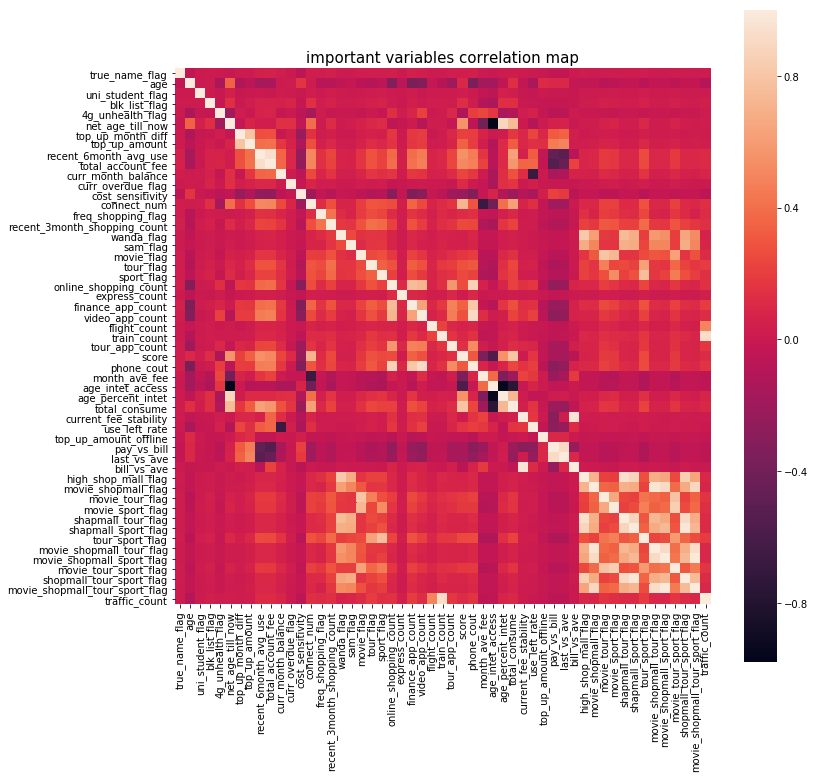

In [469]:
corrmat = train_data.corr(method='spearman')
f,ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,vmax=1.,square=True)
plt.title("important variables correlation map",fontsize=15)

In [470]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [471]:
params = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mae',
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'num_leaves': 31,
    'verbose': -1,
    'max_depth': -1,
    'lambda_l2':2.2, 'lambda_l1': 1.5}


In [472]:
NFOLDS = 5
train_label = train_data['score']
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=2019)
kf = kfold.split(train_data, train_label)

In [473]:
train_data_use = train_data.drop(['uid','score'], axis=1)
test_data_use = test_data.drop(['uid'], axis=1)

In [474]:
cv_pred = np.zeros(test_data.shape[0])
valid_best_l2_all = 0

feature_importance_df = pd.DataFrame()
count = 0
for i, (train_fold, validate) in enumerate(kf):
    print('fold: ',i, ' training')
    X_train, X_validate, label_train, label_validate = \
    train_data_use.iloc[train_fold, :], train_data_use.iloc[validate, :], \
    train_label[train_fold], train_label[validate]
    dtrain = lgb.Dataset(X_train, label_train)
    dvalid = lgb.Dataset(X_validate, label_validate, reference=dtrain)
    bst = lgb.train(params, dtrain, num_boost_round=10000, valid_sets=dvalid, verbose_eval=-1,early_stopping_rounds=100)
    cv_pred += bst.predict(test_data_use, num_iteration=bst.best_iteration)
    valid_best_l2_all += bst.best_score['valid_0']['l1']

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = list(X_train.columns)
    fold_importance_df["importance"] = bst.feature_importance(importance_type='split', iteration=bst.best_iteration)
    fold_importance_df["fold"] = count + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    count += 1

cv_pred /= NFOLDS
valid_best_l2_all /= NFOLDS
print('cv score for valid is: ', 1/(1+valid_best_l2_all))

C:\Users\zhangdecheng\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


fold:  0  training
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2810]	valid_0's l1: 14.798
fold:  1  training
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1929]	valid_0's l1: 14.6692
fold:  2  training
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[3061]	valid_0's l1: 14.7788
fold:  3  training
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2257]	valid_0's l1: 14.5182
fold:  4  training
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[3250]	valid_0's l1: 14.767
cv score for valid is:  0.0636689232995


In [406]:
 'lambda_l2': 5, 'lambda_l1':0 cv score for valid is:  0.0637562406959
cv score for valid is:  0.0637564465414


对年龄不做任何处理
cv score for valid is:  0.0637365200658

'lambda_l2': 2.2, 'lambda_l1': 1.5
cv score for valid is:  0.0637621096332

SyntaxError: invalid syntax (<ipython-input-406-2fd82b8319a3>, line 1)

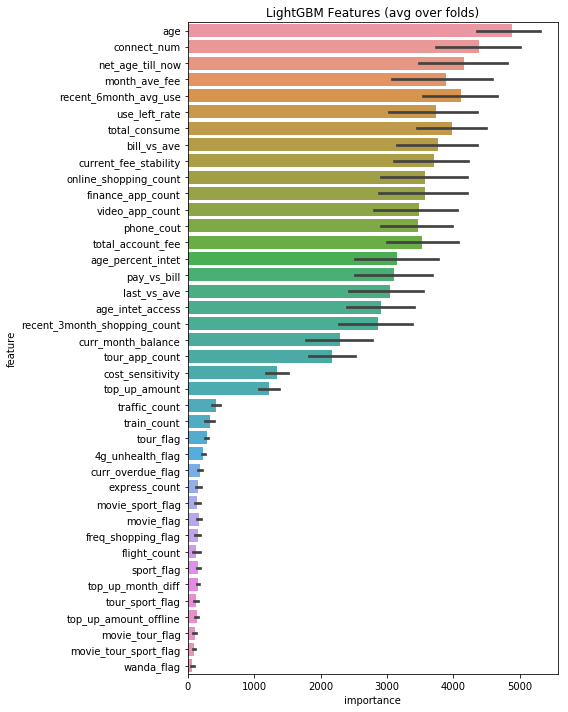

In [475]:
display_importances(feature_importance_df)

In [26]:
test_data_sub = test_data[['uid']]
test_data_sub['score'] = cv_pred
test_data_sub.columns = ['id','score']


C:\Users\zhangdecheng\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
test_data_sub['score'] = test_data_sub['score'].apply(lambda x: int(np.round(x)))

C:\Users\zhangdecheng\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
test_data_sub.to_csv('D:/data/Alpha/Alpha_6377.csv', index=False)